In [1]:
!pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

In [64]:
#Data stuff happens here
time_res = 2000
t_fine = np.linspace(0,76,time_res)

url = 'http://people.whitman.edu/~hundledr/courses/M250F03/LynxHare.txt'
df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)
df.index.name = 'Year'
df.columns = ['Hare', 'Lynx']

raw_years = df.index.to_numpy()  # [1845, ..., 1921]
shifted_years = raw_years - raw_years[0]  # [0, ..., 76]

hares = df['Hare']
lynxes = df['Lynx']

hares_interp = interp1d(shifted_years, hares, kind='cubic')
lynxes_interp = interp1d(shifted_years, lynxes, kind='cubic')

hares_fine = hares_interp(t_fine)
lynxes_fine = lynxes_interp(t_fine)

data = np.array([hares_fine, lynxes_fine]).T
data_orig = data.copy()
data_test = data[:100]
data = data[100:]
t_fine_orig = t_fine

t_fine_test = t_fine[:100]
t_fine = t_fine[100:]
data_norm = (data - np.mean(data, axis=0)) / np.std(data, axis=0)

<ipython-input-64-f4aceb10ef9a>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, delim_whitespace=True, header=None, index_col=0)


In [50]:
# Batching
batch_size = 100 #19 batches
num_batches = len(data) // batch_size
batched_data = data.reshape(num_batches, batch_size, 2)
batched_data_test = data_test.reshape(-1, batch_size, 2)

t_batches = t_fine.reshape(num_batches, batch_size)
t_batches_test = t_fine_test.reshape(-1, batch_size)

In [43]:
class LVParamLearner(nn.Module):
    def __init__(self):
      super().__init__()
      self.net_a = nn.Sequential(
            nn.Linear(2*batch_size, 64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128,8),
            nn.Tanh(),
            nn.Linear(8, 1), #4 for alpha, beta, gamma and delta
      )
      self.net_b = nn.Sequential(
            nn.Linear(2*(batch_size), 64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128,8),
            nn.Tanh(),
            nn.Linear(8, 1), #4 for alpha, beta, gamma and delta
      )
      self.net_g = nn.Sequential(
            nn.Linear(2*(batch_size), 64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128,8),
            nn.Tanh(),
            nn.Linear(8, 1), #4 for alpha, beta, gamma and delta
      )
      self.net_d = nn.Sequential(
            nn.Linear(2*(batch_size), 64),
            nn.Tanh(),
            nn.Linear(64,128),
            nn.Tanh(),
            nn.Linear(128,8),
            nn.Tanh(),
            nn.Linear(8, 1), #4 for alpha, beta, gamma and delta
      )
      self.sigm = lambda z:nn.functional.softplus(z)

    def forward(self, x):
      x = torch.flatten(torch.tensor(x,dtype=torch.float32))
      a = self.net_a(x)
      b = self.net_b(x)
      g = self.net_g(x)
      d = self.net_d(x)
      return self.sigm(a),self.sigm(b),self.sigm(g),self.sigm(d)

In [44]:
paramlearner = LVParamLearner()
optimizer = torch.optim.Adam(paramlearner.parameters(), lr=5e-4)

In [45]:
def make_deltas(alpha, beta, gamma, delta):
    def dynamics(t, y):
        return torch.stack([
            alpha * y[0] - beta * y[0] * y[1],
            delta * y[0] * y[1] - gamma * y[1]
        ])
    return dynamics

In [51]:
y0 = data[0]
y0 = torch.tensor(y0)
print(y0)
t_fine = torch.tensor(t_fine)
pred = 0
for epoch in range(250):
  for data_batch,time_batch in zip(batched_data,t_batches):
    optimizer.zero_grad()
    y0 = data_batch[0]
    y0 = torch.tensor(y0)
    time_batch = torch.tensor(time_batch)
    params = paramlearner(data_batch)

    alp,bet,gam,delt = params
    alp,bet,gam,delt = alp.squeeze(),bet.squeeze(),gam.squeeze(),delt.squeeze()
    print(alp,bet,gam,delt)
    dynamics = make_deltas(alp,bet,gam,delt)

    pred = odeint(dynamics,y0,time_batch,method='dopri5')

    target = torch.tensor(data_batch)
    loss = torch.mean(((pred - target)**2))


    if torch.isnan(loss):
      print("Loss became NaN — printing parameters")
      print(alp,bet,gam,delt)
      break
    loss.backward()
    optimizer.step()

  print(f"EPoch: {epoch} and Loss:{loss}")



tensor([22.9507, 24.8432], dtype=torch.float64)
tensor(0.4680, grad_fn=<SqueezeBackward0>) tensor(0.6068, grad_fn=<SqueezeBackward0>) tensor(0.8931, grad_fn=<SqueezeBackward0>) tensor(0.7782, grad_fn=<SqueezeBackward0>)


<ipython-input-51-70314e4ffb1d>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_fine = torch.tensor(t_fine)
<ipython-input-51-70314e4ffb1d>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  time_batch = torch.tensor(time_batch)


tensor(0.4229, grad_fn=<SqueezeBackward0>) tensor(0.6850, grad_fn=<SqueezeBackward0>) tensor(0.9484, grad_fn=<SqueezeBackward0>) tensor(0.6369, grad_fn=<SqueezeBackward0>)
tensor(0.4263, grad_fn=<SqueezeBackward0>) tensor(0.6860, grad_fn=<SqueezeBackward0>) tensor(0.8923, grad_fn=<SqueezeBackward0>) tensor(0.7050, grad_fn=<SqueezeBackward0>)
tensor(0.4354, grad_fn=<SqueezeBackward0>) tensor(0.7022, grad_fn=<SqueezeBackward0>) tensor(1.1233, grad_fn=<SqueezeBackward0>) tensor(0.5542, grad_fn=<SqueezeBackward0>)
tensor(0.3648, grad_fn=<SqueezeBackward0>) tensor(0.8334, grad_fn=<SqueezeBackward0>) tensor(0.9810, grad_fn=<SqueezeBackward0>) tensor(0.5666, grad_fn=<SqueezeBackward0>)
tensor(0.3953, grad_fn=<SqueezeBackward0>) tensor(0.8451, grad_fn=<SqueezeBackward0>) tensor(0.9202, grad_fn=<SqueezeBackward0>) tensor(0.5514, grad_fn=<SqueezeBackward0>)
tensor(0.3153, grad_fn=<SqueezeBackward0>) tensor(0.8785, grad_fn=<SqueezeBackward0>) tensor(1.2220, grad_fn=<SqueezeBackward0>) tensor(0.45

In [53]:
print(pred)
print(data)
pred_train = pred
print(paramlearner(batched_data[-1]))

tensor([[ 4.6156, 14.2631],
        [ 4.6804, 13.6743],
        [ 4.7475, 13.1102],
        [ 4.8171, 12.5700],
        [ 4.8891, 12.0525],
        [ 4.9635, 11.5568],
        [ 5.0404, 11.0820],
        [ 5.1197, 10.6272],
        [ 5.2016, 10.1915],
        [ 5.2859,  9.7742],
        [ 5.3728,  9.3745],
        [ 5.4623,  8.9915],
        [ 5.5544,  8.6247],
        [ 5.6491,  8.2733],
        [ 5.7466,  7.9367],
        [ 5.8467,  7.6142],
        [ 5.9496,  7.3052],
        [ 6.0553,  7.0092],
        [ 6.1638,  6.7256],
        [ 6.2752,  6.4540],
        [ 6.3895,  6.1937],
        [ 6.5068,  5.9443],
        [ 6.6272,  5.7053],
        [ 6.7506,  5.4764],
        [ 6.8771,  5.2570],
        [ 7.0068,  5.0468],
        [ 7.1398,  4.8454],
        [ 7.2761,  4.6524],
        [ 7.4157,  4.4674],
        [ 7.5587,  4.2902],
        [ 7.7052,  4.1203],
        [ 7.8552,  3.9575],
        [ 8.0089,  3.8015],
        [ 8.1662,  3.6519],
        [ 8.3273,  3.5086],
        [ 8.4922,  3

In [54]:
alpha,beta,gamma,delta = paramlearner(batched_data[-1])
alpha,beta,gamma,delta = alpha.squeeze(),beta.squeeze(),gamma.squeeze(),delta.squeeze()
dynamics = make_deltas(alpha,beta,gamma,delta)

new_y0 = data_test[0]
new_y0 = torch.tensor(new_y0)
t_fine_test = torch.tensor(t_fine_test)
pred = odeint(dynamics,new_y0,t_fine_test,method='dopri5')

test_loss = torch.mean(((pred - torch.tensor(data_test))**2))
print(test_loss)
print(pred)
print(data_test)

tensor(1195.1615, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor([[19.5800, 30.0900],
        [19.6909, 29.1050],
        [19.8128, 28.1542],
        [19.9454, 27.2366],
        [20.0887, 26.3509],
        [20.2425, 25.4964],
        [20.4067, 24.6718],
        [20.5811, 23.8763],
        [20.7658, 23.1089],
        [20.9607, 22.3686],
        [21.1657, 21.6547],
        [21.3807, 20.9661],
        [21.6058, 20.3021],
        [21.8409, 19.6617],
        [22.0861, 19.0443],
        [22.3413, 18.4489],
        [22.6066, 17.8750],
        [22.8819, 17.3216],
        [23.1674, 16.7882],
        [23.4631, 16.2739],
        [23.7690, 15.7783],
        [24.0851, 15.3005],
        [24.4117, 14.8400],
        [24.7487, 14.3962],
        [25.0962, 13.9685],
        [25.4544, 13.5563],
        [25.8233, 13.1591],
        [26.2031, 12.7764],
        [26.5938, 12.4076],
        [26.9956, 12.0523],
        [27.4086, 11.7100],
        [27.8330, 11.3802],
        [28.2689, 11.0625],
        [28.

In [60]:
preds = odeint(dynamics,torch.tensor(data_orig[0]),torch.tensor(t_fine_orig),method='dopri5')


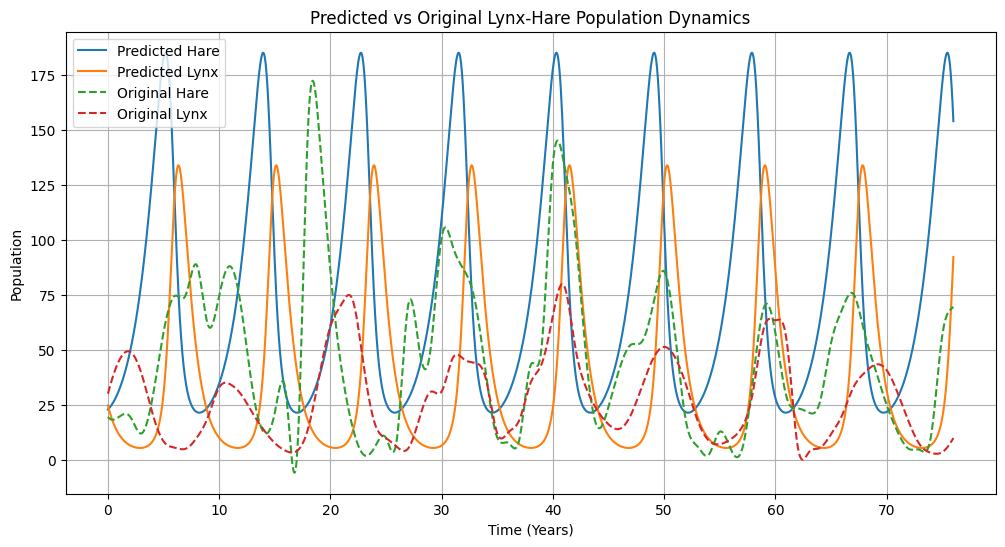

In [65]:
# prompt: Just plot preds with t_fine_orig and data_orig with t_fine_orig

import matplotlib.pyplot as plt

# Ensure preds is a numpy array for plotting
preds_np = preds.detach().numpy()

plt.figure(figsize=(12, 6))
plt.plot(t_fine_orig, preds_np[:, 0], label='Predicted Hare')
plt.plot(t_fine_orig, preds_np[:, 1], label='Predicted Lynx')
plt.plot(t_fine_orig, data_orig[:, 0], label='Original Hare', linestyle='dashed')
plt.plot(t_fine_orig, data_orig[:, 1], label='Original Lynx', linestyle='dashed')
plt.xlabel('Time (Years)')
plt.ylabel('Population')
plt.title('Predicted vs Original Lynx-Hare Population Dynamics')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Now that I have learnt the params, I will learn the functions f(t) and g(t) using Neural networks to further minimize loss
final_params = paramlearner(data_norm)
alpha,beta,gamma,delta = final_params.detach().numpy()
time_res = 2000

class FandGLearner(nn.Module):
  def __init__(self):
    super().__init__()
    self.f_net = nn.Sequential(
            nn.Linear(1, 8),
            nn.Tanh(),
            nn.Linear(8, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Tanh()
        )
    self.g_net = nn.Sequential(
            nn.Linear(1, 8),
            nn.Tanh(),
            nn.Linear(8, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Tanh()
        )
  def forward(self,t):
      f = self.f_net(t)
      g = self.g_net(t)

      return f.view(-1),g.view(-1)

In [ ]:
from scipy.interpolate import interp1d

def make_dynamics_with_f_g(alpha, beta, gamma, delta, funcLearner):

    def dynamics(t, y):
        t_inp = t.view(1,1)
        f,g = funcLearner(t_inp)
        f_val,g_val = f.squeeze(),g.squeeze()
        return torch.stack([
            alpha * y[0] - beta * y[0] * y[1] + f_val,
            delta * y[0] * y[1] - gamma * y[1] + g_val
        ])
    return dynamics

In [ ]:
print(time_res)

In [ ]:
pred = 0
funcLearner = FandGLearner()
optimizer = torch.optim.Adam(funcLearner.parameters(), lr=2e-4)
t_fine_1d = torch.tensor(t_fine,dtype=torch.float32)
t_fine_1d = t_fine_1d.view(-1)
t_fine = torch.tensor(t_fine,dtype=torch.float32)
y0 = torch.tensor(y0,dtype=torch.float32)


for epoch in range(25):
  optimizer.zero_grad()

  target = torch.tensor(data_norm)

  dynamics = make_dynamics_with_f_g(alpha,beta,gamma,delta,funcLearner)
  pred = odeint(dynamics,y0,t_fine,method='rk4')

  loss = torch.mean((pred - target)**2)
  loss.backward()
  optimizer.step()
  print(f"Epoch: {epoch} and Loss:{loss}")

In [ ]:
# prompt: Plot the real data versus my latest predicted data

import numpy as np
import matplotlib.pyplot as plt

# De-normalize the predictions and original data for plotting
pred_denorm = pred.detach().numpy() * np.std(data) + np.mean(data)
data_denorm = data_norm * np.std(data) + np.mean(data)

plt.figure(figsize=(10, 6))

# Plot the real data
plt.plot(t_fine, hares_fine, 'o-', label='Real Hare Data')
plt.plot(t_fine, lynxes_fine, 'o-', label='Real Lynx Data')

# Plot the latest predicted data
plt.plot(t_fine, pred_denorm[:, 0], '--', label='Predicted Hare Data')
plt.plot(t_fine, pred_denorm[:, 1], '--', label='Predicted Lynx Data')

plt.xlabel('Year')
plt.ylabel('Population')
plt.title('Real vs. Predicted Lynx-Hare Populations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# prompt: Plot t_fine vesus corresponding f and g values

import matplotlib.pyplot as plt
# Get the learned f and g values across the time steps
f_values = []
g_values = []
with torch.no_grad():
  for t in t_fine:
    t_inp = t.view(1,1)
    f, g = funcLearner(t_inp)
    f_values.append(f.item())
    g_values.append(g.item())

plt.figure(figsize=(10, 6))
plt.plot(t_fine, f_values, label='Learned f(t)')
plt.plot(t_fine, g_values, label='Learned g(t)')
plt.xlabel('Time (t)')
plt.ylabel('Function Value')
plt.title('Learned f(t) and g(t) over Time')
plt.legend()
plt.grid(True)
plt.show()